In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')
!ln -s drive/MyDrive/Astrodinamica planet"""


Mounted at /content/drive


### **Second order perturbations in orbital elements of minor bodies**

In [ ]:
!pip install spiceypy
import spiceypy as spy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 34.5 MB/s 


In [ ]:
#Kernel de tiempos 
!wget -P planet/ https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls


--2022-10-14 22:35:42--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5257 (5.1K) [text/plain]
Saving to: ‘planet/naif0012.tls.4’

naif0012.tls.4      100%[===================>]   5.13K  --.-KB/s    in 0s      

2022-10-14 22:35:43 (160 MB/s) - ‘planet/naif0012.tls.4’ saved [5257/5257]



In [ ]:
!wget -P planet/ https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de430.bsp
#Input parameters #Kernel of planets of the solar system including the Moon

--2022-10-14 22:35:44--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de430.bsp
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119741440 (114M)
Saving to: ‘planet/de430.bsp.2’

de430.bsp.2         100%[===================>] 114.19M  34.9MB/s    in 3.3s    

2022-10-14 22:35:48 (34.9 MB/s) - ‘planet/de430.bsp.2’ saved [119741440/119741440]



In [ ]:
spy.furnsh("planet/de430.bsp") #Load kernel planets including the Moon 
spy.furnsh("planet/2004953.bsp") #Loading NEO 4953 Kernel
spy.furnsh("planet/2005587.bsp") #Load NEO 5587 kernel
#(body numbered in aa_sumarize naif, ephem time, reference sys, with respect to which body)
XMoon_, tl_Moon_ = spy.spkgeo(301,0,'ECLIPJ2000',10) #Moon relative to the Sun
XMoonw, tl_Moonw = spy.spkezr('MOON',0,'ECLIPJ2000','None','SUN')
XEarth_, tl_Earth_ = spy.spkgeo(3,0,'ECLIPJ2000',10) #Earth relative to the Sun
XEarthw, tl_Earthw = spy.spkezr('EARTH_BARYCENTER',0,'ECLIPJ2000','None','SUN')
#X4953_, tl_4953_ = spy.spkgeo(301,0,'ECLIPJ2000',10) #Moon relative to the Sun
X4953w, tl_4953w = spy.spkezr('2004953',0,'ECLIPJ2000','None','SUN')
X5587w, tl_5587w = spy.spkezr('2005587',0,'ECLIPJ2000','None','SUN')
#same as above but with named bodies

In [ ]:
#Numerical data acquisition for calculation of the Earth-Moon-NEA orbit.
XEarthn = []
XMoonn = []
XNEA_4953 = []
XNEA_5587 = []
for t in np.linspace(0,84600*365*300,1000):
 XEarth, tl_Earth = spy.spkgeo(3,t,'ECLIPJ2000',10)
 XEarthn.append(XEarth)
 XMoon, tl_Moon = spy.spkgeo(301,t,'ECLIPJ2000',10)
 XMoonn.append(XMoon)
 X4953, tl_4953 = spy.spkgeo(2004953,t,'ECLIPJ2000',10)
 XNEA_4953.append(X4953)
 X5587, tl_4953 = spy.spkgeo(2005587,t,'ECLIPJ2000',10)
 XNEA_5587.append(X5587)



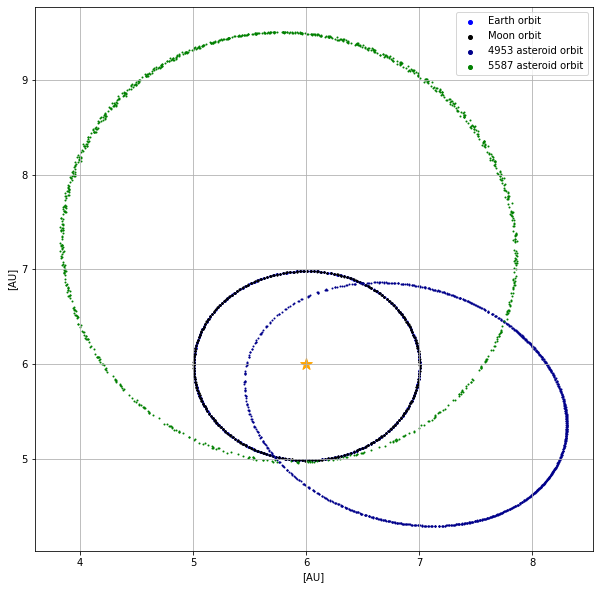

In [ ]:
#Graphing of Earth-Moon-NEA orbits with respect to the Sun

AU_scale = 1.496e8
XEarthn = np.array(XEarthn)/AU_scale
XMoonn = np.array(XMoonn)/AU_scale
XNEA_4953 =np.array(XNEA_4953)/AU_scale
XNEA_5587 =np.array(XNEA_5587)/AU_scale
move_sr = 6
#Xganymeden = np.array(Xganymeden)
plt.figure(figsize=(10,10))
plt.scatter(0+move_sr,0+move_sr,150, color='orange', marker='*')
plt.scatter(XEarthn[:,0]+move_sr, XEarthn[:,1]+move_sr, 1, color='blue', label='Earth orbit')
plt.scatter(XMoonn[:,0]+move_sr, XMoonn[:,1]+move_sr, 1, color='black', label='Moon orbit')
plt.scatter(XNEA_4953[:,0]+move_sr, XNEA_4953[:,1]+move_sr, 1, color='darkblue', label='4953 asteroid orbit')
plt.scatter(XNEA_5587[:,0]+move_sr, XNEA_5587[:,1]+move_sr, 1, color='green', label='5587 asteroid orbit')
plt.xlabel('[AU]')
plt.ylabel('[AU]')
#plt.ylim(1.4e8,1.5e8)
#plt.xlim(-3e7,-2.5e7)
#plt.scatter(Xganymeden[:,0], Xganymeden[:,1], 1, color='brown')
plt.grid()
plt.legend(markerscale=4., scatterpoints=1, fontsize=10)

The disturbances are observed in the space of the orbital elements, we regularly use eccentricity and the semi-major axis, in general the orbital parameters are those who define the state of a body, in the field of astrodynamics. The orbital elements are: $(q,e,I,\Omega,\omega,M)$

In [ ]:
#Let's use a spice routine that transforms state vectors into orbital elements: oscltx

mu=1.32712440041939377e11 #Mass parameter of the Sun-Earth-Moon-NEO system (investigate = GM)
dots = 1200
r_Earth=np.zeros((dots,3))
r_Moon=np.zeros((dots,3))
r_4953=np.zeros((dots,3))
r_5587=np.zeros((dots,3))

OE_Earth=np.zeros((dots,11))
OE_Moon=np.zeros((dots,11))
OE_4953=np.zeros((dots,11))
OE_5587=np.zeros((dots,11))


for i,t in enumerate(np.linspace(0,365*86400*100,dots)):
  X_Earth,tl_Earth=spy.spkgeo(3,t,"ECLIPJ2000",10)
  r_Earth[i]=X_Earth[:3]
  OE_Earth[i]=spy.oscltx(X_Earth,t,mu)

  X_Moon,tl_Moon=spy.spkgeo(301,t,"ECLIPJ2000",10)
  r_Moon[i]=X_Moon[:3]
  OE_Moon[i]=spy.oscltx(X_Moon,t,mu)

  X_4953,tl_4953=spy.spkgeo(2004953,t,"ECLIPJ2000",10)
  r_4953[i]=X_4953[:3]
  OE_4953[i]=spy.oscltx(X_4953,t,mu)

  X_5587,tl_5587=spy.spkgeo(2005587,t,"ECLIPJ2000",10)
  r_5587[i]=X_5587[:3]
  OE_5587[i]=spy.oscltx(X_5587,t,mu)

## Plotting orbital elements of NEOS 4953 (left column) and 5587(right column)

In [ ]:
OET = pd.read_excel('Orbital_elements_GMO.xlsx')
OET

,Designation,Source,a,e,i,long_node,arg_perh
0,4953,JPL,1.372137,0.651209,24.339792,77.714782,77.963263
1,4953,GAIA,1.392277,0.633311,23.981787,73.406773,76.916661
2,4953,OUR METHOD,1.621606,0.657428,24.373884,77.553427,77.921040
3,5587,JPL,2.195332,0.552834,18.125233,196.124161,86.197259
4,5587,GAIA,2.285782,0.593491,18.089334,196.189927,75.066284
5,5587,OUR METHOD,2.397615,0.544170,18.094648,189.920475,86.827518


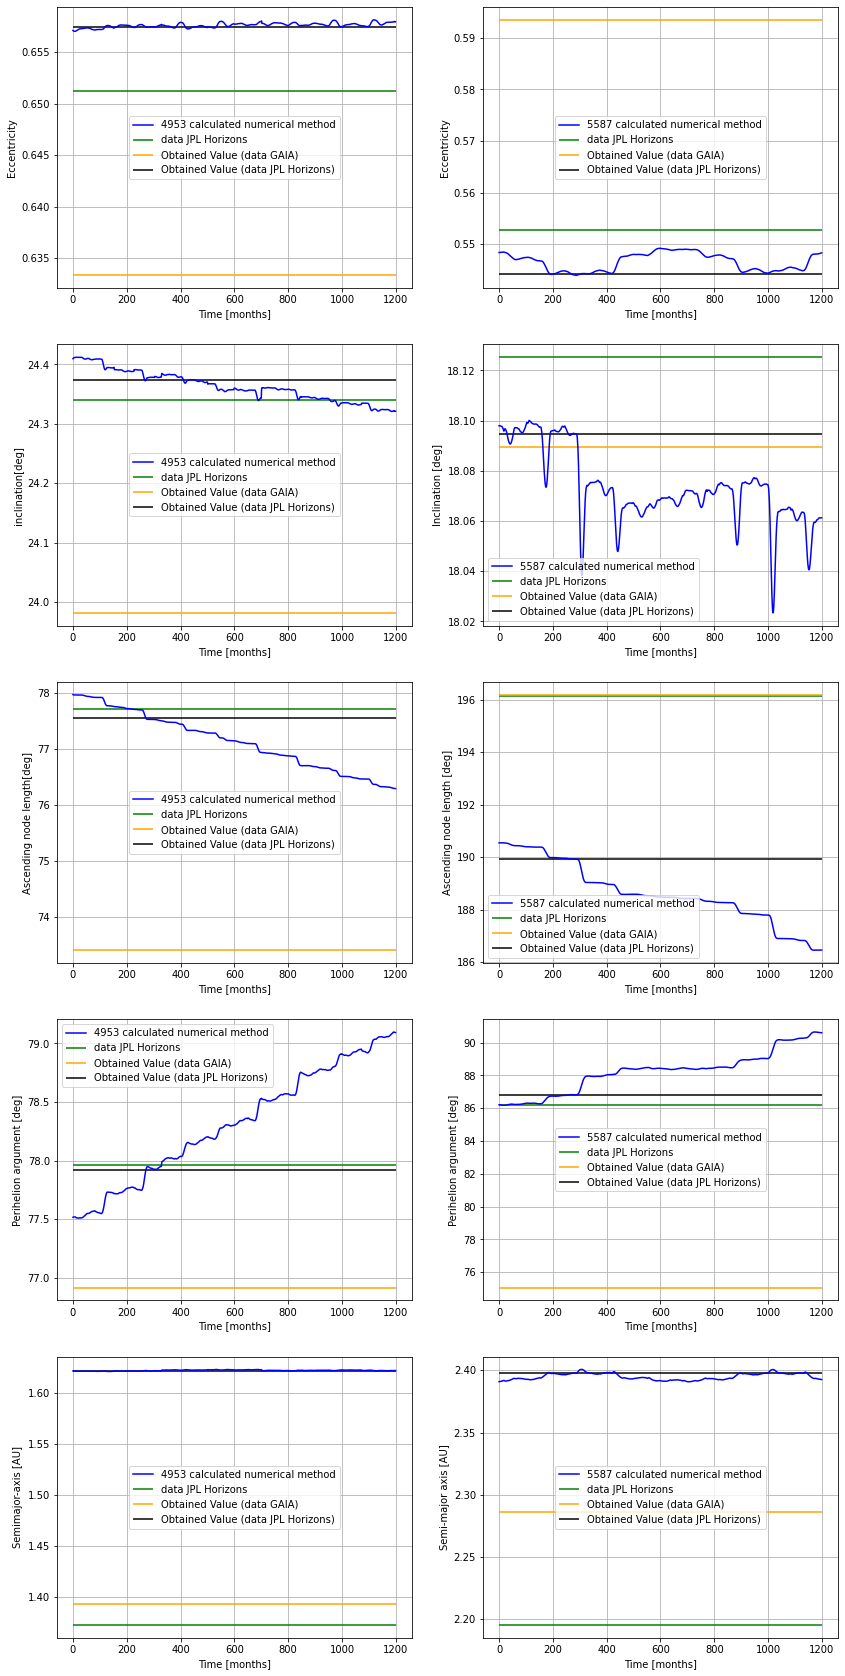

In [ ]:
#plt.plot(OE_Earth[:,1],label="Earth", color='blue')
#plt.plot(OE_Moon[:,1],label="Moon", color='gray')
plt.figure(figsize=(14,30))

#Eccentricity
plt.subplot(521)
plt.plot(OE_4953[:,1], color='blue', label='4953 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Eccentricity')
plt.hlines(OET.iloc[0,3], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[1,3], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[2,3], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.legend(loc="center", markerscale=2., scatterpoints=1, fontsize=10)
plt.grid()

plt.subplot(522)
plt.plot(OE_5587[:,1], color='blue', label='5587 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Eccentricity')
plt.hlines(OET.iloc[3,3], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[4,3], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[5,3], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="center", markerscale=2., scatterpoints=1, fontsize=10)

#Inclination
plt.subplot(523)
plt.plot(OE_4953[:,2]*(180/np.pi), color='blue', label='4953 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('inclination[deg]')
plt.hlines(OET.iloc[0,4], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[1,4], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[2,4], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="center", markerscale=2., scatterpoints=1, fontsize=10)

plt.subplot(524)
plt.plot(OE_5587[:,2]*(180/np.pi), color='blue', label='5587 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Inclination [deg]')
plt.hlines(OET.iloc[3,4], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[4,4], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[5,4], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="lower left", markerscale=2., scatterpoints=1, fontsize=10)


#ascending node length
plt.subplot(525)
plt.plot(OE_4953[:,3]*(180/np.pi), color='blue', label='4953 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Ascending node length[deg]')
plt.hlines(OET.iloc[0,5], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[1,5], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[2,5], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="center", markerscale=2., scatterpoints=1, fontsize=10)

plt.subplot(526)
plt.plot(OE_5587[:,3]*(180/np.pi), color='blue', label='5587 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Ascending node length [deg]')
plt.hlines(OET.iloc[3,5], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[4,5], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[5,5], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="lower left", markerscale=2., scatterpoints=1, fontsize=10)


#Perihelion argument
plt.subplot(527)
plt.plot(OE_4953[:,4]*(180/np.pi), color='blue', label='4953 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Perihelion argument [deg]')
plt.hlines(OET.iloc[0,6], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[1,6], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[2,6], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="upper left", markerscale=2., scatterpoints=1, fontsize=10)

plt.subplot(528)
plt.plot(OE_5587[:,4]*(180/np.pi), color='blue', label='5587 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Perihelion argument [deg]')
plt.hlines(OET.iloc[3,6], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[4,6], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[5,6], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="center", markerscale=2., scatterpoints=1, fontsize=10)


#Semimajor axis
plt.subplot(529)
plt.plot(OE_4953[:,9]*(1/1.496e8), color='blue', label='4953 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Semimajor-axis [AU]')
plt.hlines(OET.iloc[0,2], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[1,2], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[2,2], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="center", markerscale=2., scatterpoints=1, fontsize=10)

plt.subplot(5,2,10)
plt.plot(OE_5587[:,9]*(1/1.496e8), color='blue', label='5587 calculated numerical method')
plt.xlabel('Time [months]')
plt.ylabel('Semi-major axis [AU]')
plt.hlines(OET.iloc[3,2], xmin=0, xmax=dots, color='green', label='data JPL Horizons')
plt.hlines(OET.iloc[4,2], xmin=0, xmax=dots, color='orange', label='Obtained Value (data GAIA)')
plt.hlines(OET.iloc[5,2], xmin=0, xmax=dots, color='black', label='Obtained Value (data JPL Horizons)')
plt.grid()
plt.legend(loc="center", markerscale=2., scatterpoints=1, fontsize=10)


